In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
import sklearn.feature_extraction.text
import sklearn.model_selection
import sklearn.linear_model
import sklearn.svm
import sklearn.neighbors
import gensim.models


#Ease of Life libraries used to simulate progression of slow algorithms
from ipywidgets import IntProgress
from IPython.display import display
import time

# Data Preperation
We first load the data as expected. The fold process is done by breaking the data into 5 different sets. Each time we run the split code, 5 new folds are created. Nothing more to be said here.

In [3]:
#Load Data
businesses = pd.read_csv("philly_restaurants_categories.csv", encoding="latin")

reviews = pd.read_csv("filtered_reviews.csv", encoding="latin")
#Fetch the reviews we care about
reviews = reviews[reviews["business_id"].isin(businesses["business_id"])]
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155553 entries, 3 to 893888
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   review_id    155553 non-null  object 
 1   user_id      155553 non-null  object 
 2   business_id  155553 non-null  object 
 3   stars        155553 non-null  float64
 4   useful       155553 non-null  int64  
 5   funny        155553 non-null  int64  
 6   cool         155553 non-null  int64  
 7   text         155553 non-null  object 
 8   date         155553 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 11.9+ MB


In [6]:
documents = reviews.groupby(["business_id"])["text"].sum().to_frame()

#Suffle the documents to get different Folds each time.
documents = documents.sample(frac=1)
splitDocuments = []
for i in range(5):
    if i == 4:
        splitDocuments.append(documents[i*190:])
        break
    splitDocuments.append(documents[i*190:(i+1)*190])

# Part 1: TF-IDF 
We start off using the TF-IDF vectorization method. By applying sklearn's vectorizer, we transform each summed review into a vector. By mirroring a similar but generalized approach as in the previous exercise set, we use 3000 features and the common english stopwords. Therafter, we train the three models (SVM, KNN and LogReg), and calculate the results.

In [30]:
loadingBar = IntProgress(min=0, max=5*4) # instantiate the bar
display(loadingBar)

svm_cm, knn_cm, lr_cm = -1, -1, -1
svm_precision, knn_precision, lr_precision = 0, 0, 0
svm_recall, knn_recall, lr_recall = 0, 0, 0
svm_f1, knn_f1, lr_f1 = 0, 0, 0

for fold in range(5):
    #Get each train/test set
    testData = splitDocuments[fold].reset_index()
    trainData = documents.copy().reset_index()
    trainData = trainData[~trainData["business_id"].isin(testData["business_id"])]

    #Train the vectorizer
    vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_features=3_000, stop_words="english")
    matrix = vectorizer.fit_transform(trainData["text"]).toarray()
    trainData["vector"] = [matrix[i].tolist() for i in range(len(matrix))]
    trainData = trainData.merge(right=businesses, left_on="business_id", right_on="business_id")

    #Transform the Test data for predicting.
    matrix = vectorizer.transform(testData["text"]).toarray()
    testData["vector"] = [matrix[i].tolist() for i in range(len(matrix))]
    testData = testData.merge(right=businesses, left_on="business_id", right_on="business_id")
    loadingBar.value += 1
    
    #SVM
    svm = sklearn.svm.SVC()
    svm.fit(list(trainData["vector"]), trainData["category"])
    pred = svm.predict(list(testData["vector"]))
    testData["svm_predict"] = pred
    loadingBar.value += 1
    
    #KNN
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3)
    knn.fit(list(trainData["vector"]), trainData["category"])
    pred = knn.predict(list(testData["vector"]))
    testData["knn_predict"] = pred
    loadingBar.value += 1
    
    #<!-- Last fold should get some specific words!! --!>
    #Logistic Regression
    logReg = sklearn.linear_model.LogisticRegression()
    logReg.fit(list(trainData["vector"]), trainData["category"])

    pred = logReg.predict(list(testData["vector"]))
    testData["lr_predict"] = pred
    loadingBar.value += 1
    
    if fold == 4:      
        wordMap = vectorizer.vocabulary_
        wordMap = { j:i for i,j in wordMap.items()}

        values = logReg.coef_
        flatValues = np.sort(values.flatten())

        highestWords = []
        highestValues = np.flip(flatValues[-20:])
        for v in highestValues:
            i,j = np.where(np.isclose(values, v))
            i, j = i[0], j[0]
            highestWords.append(wordMap[j])


        highestValues = flatValues[:20]
        lowestWords = []
        for v in highestValues:
            i,j = np.where(np.isclose(values, v))
            i, j = i[0], j[0]
            lowestWords.append(wordMap[j])

        print("Highest Valued Words: \n", ", ".join(highestWords), "\n")
        print("Lowest Negative Valued Words: \n", ", ".join(lowestWords))
    
    #Calculate F1, precision recall and confusion
    #Confusion Matrixes
    _svm_cm = sklearn.metrics.confusion_matrix(testData["category"], testData["svm_predict"])
    _knn_cm = sklearn.metrics.confusion_matrix(testData["category"], testData["knn_predict"])
    _lr_cm = sklearn.metrics.confusion_matrix(testData["category"], testData["lr_predict"])
    
    if fold == 0:
        svm_cm, knn_cm, lr_cm = _svm_cm, _knn_cm, _lr_cm
    else:
        svm_cm += _svm_cm
        knn_cm += _knn_cm
        lr_cm += _lr_cm
       
    svm_precision += sklearn.metrics.precision_score(testData["category"], testData["svm_predict"], average="macro")
    knn_precision += sklearn.metrics.precision_score(testData["category"], testData["knn_predict"], average="macro")
    lr_precision += sklearn.metrics.precision_score(testData["category"], testData["lr_predict"], average="macro")

    svm_recall += sklearn.metrics.recall_score(testData["category"], testData["svm_predict"], average="macro")
    knn_recall += sklearn.metrics.recall_score(testData["category"], testData["knn_predict"], average="macro")
    lr_recall += sklearn.metrics.recall_score(testData["category"], testData["lr_predict"], average="macro")

    svm_f1 += sklearn.metrics.f1_score(testData["category"], testData["svm_predict"], average="macro")
    knn_f1 += sklearn.metrics.f1_score(testData["category"], testData["knn_predict"], average="macro")
    lr_f1 += sklearn.metrics.f1_score(testData["category"], testData["lr_predict"], average="macro")


IntProgress(value=0, max=20)

Highest Valued Words: 
 sushi, burger, pizza, italian, fries, pasta, ramen, rice, burgers, korean, wine, breakfast, mcdonald, japanese, wendy, wings, drive, bread, chinese, hibachi 

Lowest Negative Valued Words: 
 sushi, pizza, italian, burger, sushi, fries, pasta, burger, cheese, ramen, rice, ramen, sandwich, italian, pizza, fries, wings, burgers, pasta, wine


# TF-IDF Words
Intrestingly, the highest and lowest valued words seem to be almost identical! This makes sense, since words that are important identifiers for each category, are also bad identifiers for other categories. "Sushi" for example is a high valued word for the "Japanese" category but a very negative word for "Burger" and "Italian".

In [8]:
#Function to generate multiple confusion matrixes
def generateConfusionMatrix(cm, index=-1, name=""):
    if index != -1:
        ax = plt.subplot(130+index)
        plt.subplot(1,3,index)
        plt.title(name)
    else:
        ax = plt.subplot(111)
    ax.matshow(cm, cmap="hot")
    for i in range(len(cm)):
        for j in range(len(cm[0])):
            ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large', color="cyan")

In [31]:
print("============PRECISION============")
print("SVM : ", str(svm_precision/5)[:5])
print("KNN : ", str(knn_precision/5)[:5])
print("LogReg : ", str(lr_precision/5)[:5])

print("============RECALL============")
print("SVM : ", str(svm_recall/5)[:5])
print("KNN : ", str(knn_recall/5)[:5])
print("LogReg : ", str(lr_recall/5)[:5])

print("============F1 SCORE============")
print("SVM : ", str(svm_f1/5)[:5])
print("KNN : ", str(knn_f1/5)[:5])
print("LogReg : ", str(lr_f1/5)[:5])

============PRECISION============
SVM :  0.928
KNN :  0.910
LogReg :  0.928
============RECALL============
SVM :  0.923
KNN :  0.905
LogReg :  0.922
============F1 SCORE============
SVM :  0.925
KNN :  0.907
LogReg :  0.924


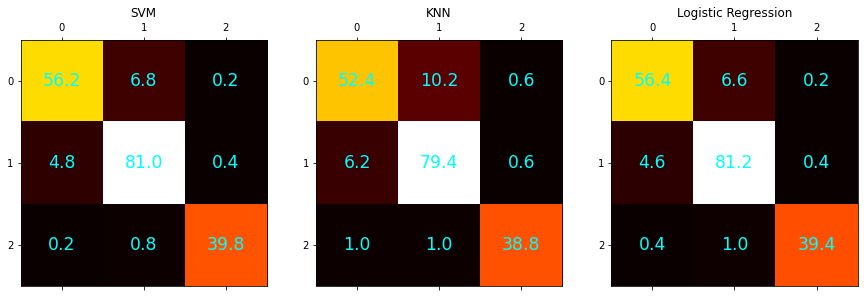

In [117]:
plt.figure(figsize=(15,10))
generateConfusionMatrix(svm_cm/5, index=1, name="SVM")
generateConfusionMatrix(knn_cm/5, index=2, name="KNN")
generateConfusionMatrix(lr_cm/5, index=3, name="Logistic Regression")

# Part 2 - Embeddings

## CBOW

For each embedding, the same code was used as in TF-IDF. This time however, we train our CBOW embedding with our words, and generate the vectors using the Average of each review's vectorized words.

In [10]:
#CBOW
loadingBar = IntProgress(min=0, max=5*4) # instantiate the bar
display(loadingBar)

svm_cm, knn_cm, lr_cm = -1, -1, -1
svm_precision, knn_precision, lr_precision = 0, 0, 0
svm_recall, knn_recall, lr_recall = 0, 0, 0
svm_f1, knn_f1, lr_f1 = 0, 0, 0

for fold in range(5):
    #Get each train/test set
    testData = splitDocuments[fold].reset_index()
    trainData = documents.copy().reset_index()
    trainData = trainData[~trainData["business_id"].isin(testData["business_id"])]
    trainData["text"] = trainData["text"].apply(lambda x : x.split(" "))
    testData["text"] = testData["text"].apply(lambda x : x.split(" "))

    embedding_CBOW = gensim.models.Word2Vec(trainData["text"]) 
    
    trainVectors = [np.array([embedding_CBOW.wv[x] for x in y if x in embedding_CBOW.wv.key_to_index]).mean(axis = 0) for y in trainData["text"]]
    trainData["vector"] = trainVectors
    
    testVectors = [np.array([embedding_CBOW.wv[x] for x in y if x in embedding_CBOW.wv.key_to_index]).mean(axis = 0) for y in testData["text"]]
    testData["vector"] = testVectors
    
    trainData = trainData.merge(right=businesses, left_on="business_id", right_on="business_id")
    testData = testData.merge(right=businesses, left_on="business_id", right_on="business_id")
    loadingBar.value += 1
    
    #SVM
    svm = sklearn.svm.SVC()
    svm.fit(list(trainData["vector"]), trainData["category"])
    pred = svm.predict(list(testData["vector"]))
    testData["svm_predict"] = pred
    loadingBar.value += 1
    
    #KNN
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3)
    knn.fit(list(trainData["vector"]), trainData["category"])
    pred = knn.predict(list(testData["vector"]))
    testData["knn_predict"] = pred
    loadingBar.value += 1
    
    #<!-- Last fold should get some specific words!! --!>
    #Logistic Regression
    logReg = sklearn.linear_model.LogisticRegression(max_iter=300)
    logReg.fit(list(trainData["vector"]), trainData["category"])

    pred = logReg.predict(list(testData["vector"]))
    testData["lr_predict"] = pred
    loadingBar.value += 1
    
    
    #Calculate F1, precision recall and confusion
    #Confusion Matrixes
    _svm_cm = sklearn.metrics.confusion_matrix(testData["category"], testData["svm_predict"])
    _knn_cm = sklearn.metrics.confusion_matrix(testData["category"], testData["knn_predict"])
    _lr_cm = sklearn.metrics.confusion_matrix(testData["category"], testData["lr_predict"])
    
    if fold == 0:
        svm_cm, knn_cm, lr_cm = _svm_cm, _knn_cm, _lr_cm
    else:
        svm_cm += _svm_cm
        knn_cm += _knn_cm
        lr_cm += _lr_cm
       
    svm_precision += sklearn.metrics.precision_score(testData["category"], testData["svm_predict"], average="macro")
    knn_precision += sklearn.metrics.precision_score(testData["category"], testData["knn_predict"], average="macro")
    lr_precision += sklearn.metrics.precision_score(testData["category"], testData["lr_predict"], average="macro")

    svm_recall += sklearn.metrics.recall_score(testData["category"], testData["svm_predict"], average="macro")
    knn_recall += sklearn.metrics.recall_score(testData["category"], testData["knn_predict"], average="macro")
    lr_recall += sklearn.metrics.recall_score(testData["category"], testData["lr_predict"], average="macro")

    svm_f1 += sklearn.metrics.f1_score(testData["category"], testData["svm_predict"], average="macro")
    knn_f1 += sklearn.metrics.f1_score(testData["category"], testData["knn_predict"], average="macro")
    lr_f1 += sklearn.metrics.f1_score(testData["category"], testData["lr_predict"], average="macro")


IntProgress(value=0, max=20)

In [11]:
print("============PRECISION============")
print("SVM : ", str(svm_precision/5)[:5])
print("KNN : ", str(knn_precision/5)[:5])
print("LogReg : ", str(lr_precision/5)[:5])

print("============RECALL============")
print("SVM : ", str(svm_recall/5)[:5])
print("KNN : ", str(knn_recall/5)[:5])
print("LogReg : ", str(lr_recall/5)[:5])

print("============F1 SCORE============")
print("SVM : ", str(svm_f1/5)[:5])
print("KNN : ", str(knn_f1/5)[:5])
print("LogReg : ", str(lr_f1/5)[:5])

============PRECISION============
SVM :  0.873
KNN :  0.870
LogReg :  0.895
============RECALL============
SVM :  0.854
KNN :  0.850
LogReg :  0.882
============F1 SCORE============
SVM :  0.861
KNN :  0.858
LogReg :  0.887


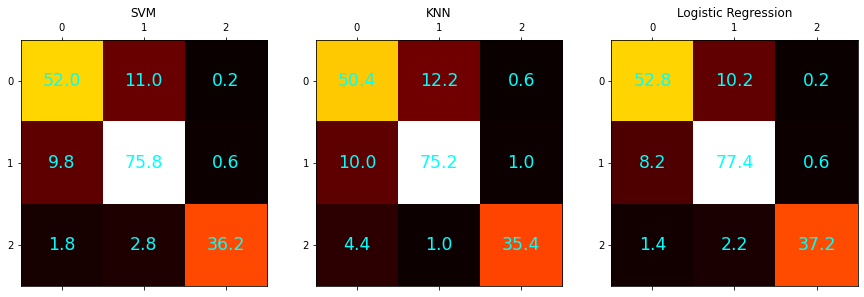

In [23]:
plt.figure(figsize=(15,10))
generateConfusionMatrix(svm_cm/5, index=1, name="SVM")
generateConfusionMatrix(knn_cm/5, index=2, name="KNN")
generateConfusionMatrix(lr_cm/5, index=3, name="Logistic Regression")

# CBOW - SkipGram

In [12]:
#SKIP GRAM
loadingBar = IntProgress(min=0, max=5*4) # instantiate the bar
display(loadingBar)

svm_cm, knn_cm, lr_cm = -1, -1, -1
svm_precision, knn_precision, lr_precision = 0, 0, 0
svm_recall, knn_recall, lr_recall = 0, 0, 0
svm_f1, knn_f1, lr_f1 = 0, 0, 0

for fold in range(5):
    #Get each train/test set
    testData = splitDocuments[fold].reset_index()
    trainData = documents.copy().reset_index()
    trainData = trainData[~trainData["business_id"].isin(testData["business_id"])]
    trainData["text"] = trainData["text"].apply(lambda x : x.split(" "))
    testData["text"] = testData["text"].apply(lambda x : x.split(" "))

    embedding_SKIP = gensim.models.Word2Vec(trainData["text"], sg=1) 
    
    trainVectors = [np.array([embedding_SKIP.wv[x] for x in y if x in embedding_SKIP.wv.key_to_index]).mean(axis = 0) for y in trainData["text"]]
    trainData["vector"] = trainVectors
    
    testVectors = [np.array([embedding_SKIP.wv[x] for x in y if x in embedding_SKIP.wv.key_to_index]).mean(axis = 0) for y in testData["text"]]
    testData["vector"] = testVectors
    
    trainData = trainData.merge(right=businesses, left_on="business_id", right_on="business_id")
    testData = testData.merge(right=businesses, left_on="business_id", right_on="business_id")
    loadingBar.value += 1
    
    #SVM
    svm = sklearn.svm.SVC()
    svm.fit(list(trainData["vector"]), trainData["category"])
    pred = svm.predict(list(testData["vector"]))
    testData["svm_predict"] = pred
    loadingBar.value += 1
    
    #KNN
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3)
    knn.fit(list(trainData["vector"]), trainData["category"])
    pred = knn.predict(list(testData["vector"]))
    testData["knn_predict"] = pred
    loadingBar.value += 1
    
    #Logistic Regression
    logReg = sklearn.linear_model.LogisticRegression(max_iter=300)
    logReg.fit(list(trainData["vector"]), trainData["category"])

    pred = logReg.predict(list(testData["vector"]))
    testData["lr_predict"] = pred
    loadingBar.value += 1
    
    
    #Calculate F1, precision recall and confusion
    #Confusion Matrixes
    _svm_cm = sklearn.metrics.confusion_matrix(testData["category"], testData["svm_predict"])
    _knn_cm = sklearn.metrics.confusion_matrix(testData["category"], testData["knn_predict"])
    _lr_cm = sklearn.metrics.confusion_matrix(testData["category"], testData["lr_predict"])
    
    if fold == 0:
        svm_cm, knn_cm, lr_cm = _svm_cm, _knn_cm, _lr_cm
    else:
        svm_cm += _svm_cm
        knn_cm += _knn_cm
        lr_cm += _lr_cm
       
    svm_precision += sklearn.metrics.precision_score(testData["category"], testData["svm_predict"], average="macro")
    knn_precision += sklearn.metrics.precision_score(testData["category"], testData["knn_predict"], average="macro")
    lr_precision += sklearn.metrics.precision_score(testData["category"], testData["lr_predict"], average="macro")

    svm_recall += sklearn.metrics.recall_score(testData["category"], testData["svm_predict"], average="macro")
    knn_recall += sklearn.metrics.recall_score(testData["category"], testData["knn_predict"], average="macro")
    lr_recall += sklearn.metrics.recall_score(testData["category"], testData["lr_predict"], average="macro")

    svm_f1 += sklearn.metrics.f1_score(testData["category"], testData["svm_predict"], average="macro")
    knn_f1 += sklearn.metrics.f1_score(testData["category"], testData["knn_predict"], average="macro")
    lr_f1 += sklearn.metrics.f1_score(testData["category"], testData["lr_predict"], average="macro")


IntProgress(value=0, max=20)

In [13]:
print("============PRECISION============")
print("SVM : ", str(svm_precision/5)[:5])
print("KNN : ", str(knn_precision/5)[:5])
print("LogReg : ", str(lr_precision/5)[:5])

print("============RECALL============")
print("SVM : ", str(svm_recall/5)[:5])
print("KNN : ", str(knn_recall/5)[:5])
print("LogReg : ", str(lr_recall/5)[:5])

print("============F1 SCORE============")
print("SVM : ", str(svm_f1/5)[:5])
print("KNN : ", str(knn_f1/5)[:5])
print("LogReg : ", str(lr_f1/5)[:5])

============PRECISION============
SVM :  0.836
KNN :  0.895
LogReg :  0.844
============RECALL============
SVM :  0.772
KNN :  0.882
LogReg :  0.792
============F1 SCORE============
SVM :  0.791
KNN :  0.887
LogReg :  0.809


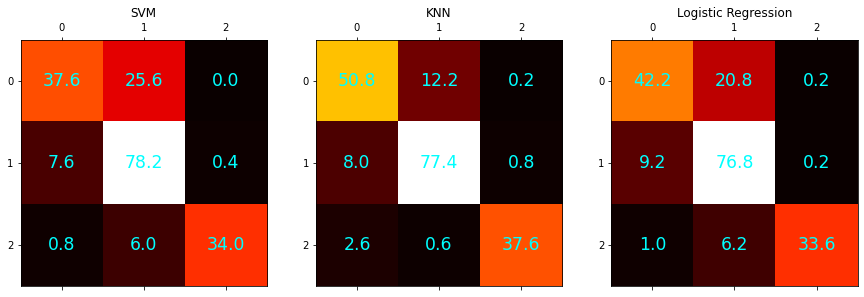

In [26]:
plt.figure(figsize=(15,10))
generateConfusionMatrix(svm_cm/5, index=1, name="SVM")
generateConfusionMatrix(knn_cm/5, index=2, name="KNN")
generateConfusionMatrix(lr_cm/5, index=3, name="Logistic Regression")

# Doc2Vec

In [14]:
#DOC2VEC
loadingBar = IntProgress(min=0, max=5*4) # instantiate the bar
display(loadingBar)

svm_cm, knn_cm, lr_cm = -1, -1, -1
svm_precision, knn_precision, lr_precision = 0, 0, 0
svm_recall, knn_recall, lr_recall = 0, 0, 0
svm_f1, knn_f1, lr_f1 = 0, 0, 0

for fold in range(5):
    #Get each train/test set
    testData = splitDocuments[fold].reset_index()
    trainData = documents.copy().reset_index()
    trainData = trainData[~trainData["business_id"].isin(testData["business_id"])]

    trainData = trainData.merge(right=businesses, left_on="business_id", right_on="business_id")
    testData = testData.merge(right=businesses, left_on="business_id", right_on="business_id")

    trainData["text"] = trainData["text"].apply(lambda x : x.split(" "))
    testData["text"] = testData["text"].apply(lambda x : x.split(" "))

    trainTags = [gensim.models.doc2vec.TaggedDocument(trainData["text"][i], [i]) for i in range(len(trainData))]
    embedding_DOC = gensim.models.doc2vec.Doc2Vec(vector_size=50)
    embedding_DOC.build_vocab(trainTags)
    embedding_DOC.train(trainTags, total_examples=embedding_DOC.corpus_count, epochs=embedding_DOC.epochs)
    
    trainData["vector"] = trainData["text"].apply(lambda x : embedding_DOC.infer_vector(x))
    testData["vector"] = testData["text"].apply(lambda x : embedding_DOC.infer_vector(x))
    loadingBar.value += 1
    
    #SVM
    svm = sklearn.svm.SVC()
    svm.fit(list(trainData["vector"]), trainData["category"])
    pred = svm.predict(list(testData["vector"]))
    testData["svm_predict"] = pred
    loadingBar.value += 1
    
    #KNN
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3)
    knn.fit(list(trainData["vector"]), trainData["category"])
    pred = knn.predict(list(testData["vector"]))
    testData["knn_predict"] = pred
    loadingBar.value += 1
    
    #<!-- Last fold should get some specific words!! --!>
    #Logistic Regression
    logReg = sklearn.linear_model.LogisticRegression(max_iter=600)
    logReg.fit(list(trainData["vector"]), trainData["category"])

    pred = logReg.predict(list(testData["vector"]))
    testData["lr_predict"] = pred
    loadingBar.value += 1
    
    
    #Calculate F1, precision recall and confusion
    #Confusion Matrixes
    _svm_cm = sklearn.metrics.confusion_matrix(testData["category"], testData["svm_predict"])
    _knn_cm = sklearn.metrics.confusion_matrix(testData["category"], testData["knn_predict"])
    _lr_cm = sklearn.metrics.confusion_matrix(testData["category"], testData["lr_predict"])
    
    if fold == 0:
        svm_cm, knn_cm, lr_cm = _svm_cm, _knn_cm, _lr_cm
    else:
        svm_cm += _svm_cm
        knn_cm += _knn_cm
        lr_cm += _lr_cm
       
    svm_precision += sklearn.metrics.precision_score(testData["category"], testData["svm_predict"], average="macro")
    knn_precision += sklearn.metrics.precision_score(testData["category"], testData["knn_predict"], average="macro")
    lr_precision += sklearn.metrics.precision_score(testData["category"], testData["lr_predict"], average="macro")

    svm_recall += sklearn.metrics.recall_score(testData["category"], testData["svm_predict"], average="macro")
    knn_recall += sklearn.metrics.recall_score(testData["category"], testData["knn_predict"], average="macro")
    lr_recall += sklearn.metrics.recall_score(testData["category"], testData["lr_predict"], average="macro")

    svm_f1 += sklearn.metrics.f1_score(testData["category"], testData["svm_predict"], average="macro")
    knn_f1 += sklearn.metrics.f1_score(testData["category"], testData["knn_predict"], average="macro")
    lr_f1 += sklearn.metrics.f1_score(testData["category"], testData["lr_predict"], average="macro")
#50 sized vector~! Same results as tfidf but less memory for more time.

IntProgress(value=0, max=20)

In [15]:
print("============PRECISION============")
print("SVM : ", str(svm_precision/5)[:5])
print("KNN : ", str(knn_precision/5)[:5])
print("LogReg : ", str(lr_precision/5)[:5])

print("============RECALL============")
print("SVM : ", str(svm_recall/5)[:5])
print("KNN : ", str(knn_recall/5)[:5])
print("LogReg : ", str(lr_recall/5)[:5])

print("============F1 SCORE============")
print("SVM : ", str(svm_f1/5)[:5])
print("KNN : ", str(knn_f1/5)[:5])
print("LogReg : ", str(lr_f1/5)[:5])

============PRECISION============
SVM :  0.933
KNN :  0.919
LogReg :  0.914
============RECALL============
SVM :  0.933
KNN :  0.917
LogReg :  0.908
============F1 SCORE============
SVM :  0.933
KNN :  0.918
LogReg :  0.911


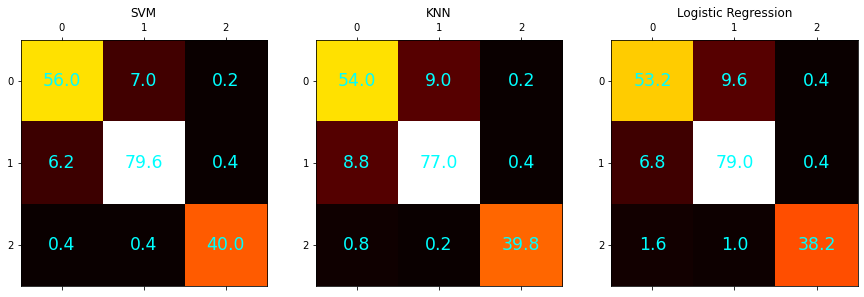

In [77]:
plt.figure(figsize=(15,10))
generateConfusionMatrix(svm_cm/5, index=1, name="SVM")
generateConfusionMatrix(knn_cm/5, index=2, name="KNN")
generateConfusionMatrix(lr_cm/5, index=3, name="Logistic Regression")

# Bonus: Google Embeddings

In [16]:
#BONUS - Google Vectors
loadingBar = IntProgress(min=0, max=4*5+10) # instantiate the bar
display(loadingBar)

google_model = gensim.models.KeyedVectors.load_word2vec_format('google/GoogleNews-vectors-negative300.bin', binary=True)
loadingBar.value += 10

svm_cm, knn_cm, lr_cm = -1, -1, -1
svm_precision, knn_precision, lr_precision = 0, 0, 0
svm_recall, knn_recall, lr_recall = 0, 0, 0
svm_f1, knn_f1, lr_f1 = 0, 0, 0

for fold in range(5):
    testData = splitDocuments[fold].reset_index()
    trainData = documents.copy().reset_index()
    trainData = trainData[~trainData["business_id"].isin(testData["business_id"])]

    trainData = trainData.merge(right=businesses, left_on="business_id", right_on="business_id")
    testData = testData.merge(right=businesses, left_on="business_id", right_on="business_id")

    trainData["text"] = trainData["text"].apply(lambda x : x.split(" "))
    testData["text"] = testData["text"].apply(lambda x : x.split(" "))

    #Remove words that do not exist in our KeyedVectors
    trainData["text"] = trainData["text"].apply(lambda x : [i for i in x if i in google_model])
    testData["text"] = testData["text"].apply(lambda x : [i for i in x if i in google_model])
    
    #Find the average of all vectors for each word per review. Use that as our vector
    trainData["vector"] = trainData["text"].apply(lambda x : sum(google_model[x])/len(x))
    testData["vector"] = testData["text"].apply(lambda x : sum(google_model[x])/len(x))
    loadingBar.value += 1
    
    #SVM
    svm = sklearn.svm.SVC()
    svm.fit(list(trainData["vector"]), trainData["category"])
    pred = svm.predict(list(testData["vector"]))
    testData["svm_predict"] = pred
    loadingBar.value += 1
    
    #KNN
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3)
    knn.fit(list(trainData["vector"]), trainData["category"])
    pred = knn.predict(list(testData["vector"]))
    testData["knn_predict"] = pred
    loadingBar.value += 1
    
    #Logistic Regression
    logReg = sklearn.linear_model.LogisticRegression(max_iter=600)
    logReg.fit(list(trainData["vector"]), trainData["category"])

    pred = logReg.predict(list(testData["vector"]))
    testData["lr_predict"] = pred
    loadingBar.value += 1
    
    
    #Calculate F1, precision recall and confusion
    #Confusion Matrixes
    _svm_cm = sklearn.metrics.confusion_matrix(testData["category"], testData["svm_predict"])
    _knn_cm = sklearn.metrics.confusion_matrix(testData["category"], testData["knn_predict"])
    _lr_cm = sklearn.metrics.confusion_matrix(testData["category"], testData["lr_predict"])
    
    if fold == 0:
        svm_cm, knn_cm, lr_cm = _svm_cm, _knn_cm, _lr_cm
    else:
        svm_cm += _svm_cm
        knn_cm += _knn_cm
        lr_cm += _lr_cm
       
    svm_precision += sklearn.metrics.precision_score(testData["category"], testData["svm_predict"], average="macro", zero_division=0)
    knn_precision += sklearn.metrics.precision_score(testData["category"], testData["knn_predict"], average="macro", zero_division=0)
    lr_precision += sklearn.metrics.precision_score(testData["category"], testData["lr_predict"], average="macro", zero_division=0)

    svm_recall += sklearn.metrics.recall_score(testData["category"], testData["svm_predict"], average="macro")
    knn_recall += sklearn.metrics.recall_score(testData["category"], testData["knn_predict"], average="macro")
    lr_recall += sklearn.metrics.recall_score(testData["category"], testData["lr_predict"], average="macro")

    svm_f1 += sklearn.metrics.f1_score(testData["category"], testData["svm_predict"], average="macro")
    knn_f1 += sklearn.metrics.f1_score(testData["category"], testData["knn_predict"], average="macro")
    lr_f1 += sklearn.metrics.f1_score(testData["category"], testData["lr_predict"], average="macro")

IntProgress(value=0, max=30)

In [17]:
print("============PRECISION============")
print("SVM : ", str(svm_precision/5)[:5])
print("KNN : ", str(knn_precision/5)[:5])
print("LogReg : ", str(lr_precision/5)[:5])

print("============RECALL============")
print("SVM : ", str(svm_recall/5)[:5])
print("KNN : ", str(knn_recall/5)[:5])
print("LogReg : ", str(lr_recall/5)[:5])

print("============F1 SCORE============")
print("SVM : ", str(svm_f1/5)[:5])
print("KNN : ", str(knn_f1/5)[:5])
print("LogReg : ", str(lr_f1/5)[:5])

============PRECISION============
SVM :  0.883
KNN :  0.894
LogReg :  0.792
============RECALL============
SVM :  0.860
KNN :  0.882
LogReg :  0.626
============F1 SCORE============
SVM :  0.869
KNN :  0.887
LogReg :  0.649


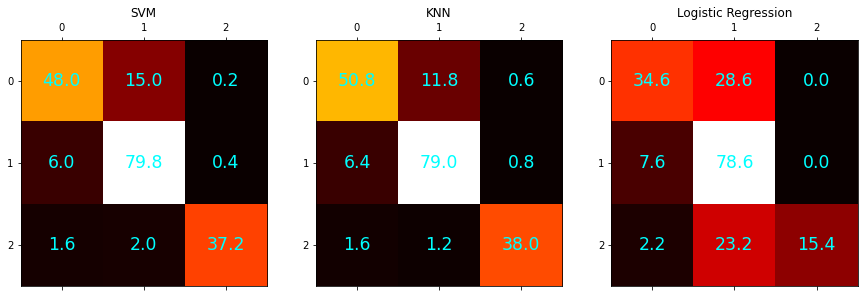

In [83]:
plt.figure(figsize=(15,10))
generateConfusionMatrix(svm_cm/5, index=1, name="SVM")
generateConfusionMatrix(knn_cm/5, index=2, name="KNN")
generateConfusionMatrix(lr_cm/5, index=3, name="Logistic Regression")

# Conclusions

| Model    | Precision  | Time  |   Features   |
|----------|------------|-------|--------------|
| TF-IDF   | ~92% with SVM/LogReg  | 1-2m |  3000   |
| CBOW     | ~89.5% with LogReg  | ~8m  |  100   |
| SKIPGRAM | ~89% with KNN  | ~10m  |  100   |
| DOC2VEC  | ~93% with SVM  | ~11m  |  50  |
| GOOGLE  |  ~89.4% with KNN |  <10m |  300  |

Each model of vectorization has its benefits for our problem.
- TF-IDF is the fastest of the 5. Using 3000 features, we reach an accuracy of ~92%. This falls to 89-90% at 50 features (which is the lowest amount of features across all models.
- CBOW an SKIPGRAM take roughly 10 minutes to complete, and provide amongst the lowest accuracies, aroun 89% with 100 features.
- DOC2VEC gives the highest accuracy of 93-94% with only 50 features! The time required is comparable to CBOW/SKIPGRAM
- Google Embeddings are faster (although the provided code runs at 10m without any modification), and provides a modest 89.4% accuracy. We did not focus on providing a more efficient structure for this model, but an optimized version shoul run at 6-8m.

Comparably, the best vectorizer appears to be DOC2VEC, giving the highest accuracy with the least features, but losing on the time required. TF-IDF on the other hand, comes second, being very fast when compared to the rest and giving a very satisfactory result for our problem. Embeddings seem to give a more accurate approach on vectorizing our data, but the problem we are working on could be easily solved with a TF-IDF vectorizer.

As for the Google Embeddings, their accuracy is higher than SKIPGRAM but lower than TF-IDF/DOC2VEC. This is to be expected, since while the Google Embeddings are heavily trained on millions of words, they are not specialized as our embeddings to the problem we are solving. Their accuracy is still impressive though.